In [2]:
import pandas as pd
import numpy as np
from datetime import datetime, date
import holidays

### Importazione dataframe

In [3]:
df1 = pd.read_csv('C:/Users/HP/Desktop/PLC_gualchierani/monitorconi_23mar_to_29mar.csv')
df2 = pd.read_csv('C:/Users/HP/Desktop/PLC_gualchierani/monitorconi_30mar_to_4apr.csv')
df3 = pd.read_csv('C:/Users/HP/Desktop/PLC_gualchierani/monitorconi_5apr_to_11apr.csv')
df4 = pd.read_csv('C:/Users/HP/Desktop/PLC_gualchierani/monitorconi_12apr_to_18apr.csv')
df5 = pd.read_csv('C:/Users/HP/Desktop/PLC_gualchierani/monitorconi_19apr_to_25apr.csv')
df6 = pd.read_csv('C:/Users/HP/Desktop/PLC_gualchierani/monitorconi_26apr_to_2mag.csv')
df7 = pd.read_csv('C:/Users/HP/Desktop/PLC_gualchierani/monitorconi_3mag_to_9mag.csv')

In [4]:
df1["measured_at"] = pd.to_datetime( df1["measured_at"] )
df2["measured_at"] = pd.to_datetime( df2["measured_at"] )
df3["measured_at"] = pd.to_datetime( df3["measured_at"] )
df4["measured_at"] = pd.to_datetime( df4["measured_at"] )
df5["measured_at"] = pd.to_datetime( df5["measured_at"] )
df6["measured_at"] = pd.to_datetime( df6["measured_at"] )
df7["measured_at"] = pd.to_datetime( df7["measured_at"] )

In [5]:
# da mezzanotte del 23/03 alle 23.59 del 29/03
mask_30mar = np.asarray( df1[ df1['measured_at'].dt.day == 30].index )
df1.drop( mask_30mar, inplace = True )

# da mezzanotte del 30/03 alle 23.59 del 4/04
mask_29mar = np.asarray( df2[ df2['measured_at'].dt.day == 29].index )
df2.drop( mask_29mar, inplace = True )

mask_5apr = np.asarray( df2[ df2['measured_at'].dt.day == 5].index )
df2.drop( mask_5apr, inplace = True )

# da mezzanotte del 5/04 alle 23.59 del 11/04
mask_4apr = np.asarray( df3[ df3['measured_at'].dt.day == 4].index )
df3.drop( mask_4apr, inplace = True )

mask_12apr = np.asarray( df3[ df3['measured_at'].dt.day == 12].index )
df3.drop( mask_12apr, inplace = True )

# da mezzanotte del 12/04 alle 23.59 del 18/04
mask_11apr = np.asarray( df4[ df4['measured_at'].dt.day == 11].index )
df4.drop( mask_11apr, inplace = True )

mask_19apr = np.asarray( df4[ df4['measured_at'].dt.day == 19].index )
df4.drop( mask_19apr, inplace = True )

# da mezzanotte del 19/04 alle 23.59 del 25/04
mask_18apr = np.asarray( df5[ df5['measured_at'].dt.day == 18].index )
df5.drop( mask_18apr, inplace = True )

mask_26apr = np.asarray( df5[ df5['measured_at'].dt.day == 26].index )
df5.drop( mask_26apr, inplace = True )

# da mezzanotte del 26/04 alle 23.59 del 2/05
mask_25apr = np.asarray( df6[ df6['measured_at'].dt.day == 25].index )
df6.drop( mask_4apr, inplace = True )

mask_3mag = np.asarray( df6[ df6['measured_at'].dt.day == 3].index )
df6.drop( mask_12apr, inplace = True )

mask_2mag = np.asarray( df7[ df7['measured_at'].dt.day == 2].index )
df7.drop( mask_2mag, inplace = True )

mask_10mag = np.asarray( df7[ df7['measured_at'].dt.day == 10].index )
df7.drop( mask_10mag, inplace = True )

# unisco i dataframe
df = pd.concat([df1, df2, df3, df4, df5, df6, df7])

In [6]:
df.drop(['id', 'tipologia_lavorazione', 'cicli_da_eseguire',
        'cicli_eseguiti', 'tempo_miscelazione_eseguito',
        'stato_tramoggia', 'tara_cono', 'lotto',
        'created_at', 'updated_at','estrusore_destinazione', 'tempo_miscelazione_richiesto',
        'destinazione_ritorno'], axis=1, inplace=True)

In [ ]:
mask_no_cono = np.asarray( df[ df['id_cono'] > 24 ].index )
df.drop( mask_no_cono, inplace = True )

In [ ]:
df.dropna(inplace=True)

In [ ]:
df.info()

### Calcolo ore lavorative

In [ ]:
dates = np.asarray(df['measured_at'].dt.date.unique())
it_holidays = holidays.Italy()
shift = 0 

In [ ]:
for date in dates:
    if it_holidays.get(date) is None:
        if date.weekday() < 5:
            shift += 3
        elif date.weekday() == 5:
            shift += 2
        else:
            pass
    else:
        print(it_holidays.get(date))

In [ ]:
shift

### Preparazione dati di supporto

In [ ]:
buffer = [n for n in range(21, 29)]
buffer.extend([n for n in range(31, 39)])

legenda_gualchierani = {
    'fuori_impianto': [0],
    'ing_zona_misc': [1],
    'catenaria_ing_misc': [45, 46],
    'navetta_serv_misc': [43],
    'pesatura': [41, 42],
    'miscelatore': [2, 8],
    'cat_usc_pieni': [3],
    'nav_serv_carr_pieni': [4],
    'nav_serv_carr_vuoti': [5],
    'buffer': buffer,
    'carroponte_1': [6],
    'carroponte_2': [7],
    'estrusore': [n for n in range(11, 19)],
    'handling_post_est': [6, 5, 4],
    'catenaria_vuoti': [47, 48],
    'catenaria_uscita_vuoti': [49],
    'pinza_vuoti': [50],
    'catenaria_parcheggi': [n for n in range(51, 58)],
    'nav_serv_parcheggi': [44],
    'manuale': [68, 70]
}

dict_states = {
    'Not_def': 0,
    'V_per_park': 1,
    'P_da_misc': 2,
    'P_da_est': 3,
    'P_remove': 4,
    'P_recheck': 5,
    'P_per_park': 6,
    'V_da_pes': 7,
    'V_remove': 8,
    'V_lavaggio': 9
}

starter = ['V_da_pes/nav_serv_carr_pieni', 'V_da_pes/nav_serv_carr_vuoti',
'V_da_pes/catenaria_vuoti', 'V_da_pes/catenaria_parcheggi',
'V_da_pes/nav_serv_parcheggi', 'V_da_pes/catenaria_ing_misc',
'V_da_pes/ing_zona_misc']

finisher = ['P_da_est/estrusore', 'Not_def/fuori_impianto']

finisher2 = ['V_per_park/estrusore', 'V_da_pes/estrusore', 'Not_def/fuori_impianto']

### Preparazione funzioni

In [ ]:
df.reset_index(drop=True, inplace=True)

In [ ]:
def naming_values(df, legenda_gualchierani, dict_states):
    for idx in df.index:
        for key in legenda_gualchierani:
            if df.loc[idx, 'ubicazione'] in legenda_gualchierani[key]:
                df.loc[idx, 'ubicazione'] = key
                break
        for key in dict_states:
            if df.loc[idx, 'stato'] == dict_states[key]:
                df.loc[idx, 'stato'] = key
                break
    return(df)

In [ ]:
df = naming_values(df, legenda_gualchierani, dict_states)

In [ ]:
#  crea il dataframe che sarà input alla funzione di individuazione della tracce
def create_rif(df):
    df['ID'] = 0
    df['CRC'] = 0
    df['rif'] = (df.stato.astype('str') + '/' + df.ubicazione.astype('str'))
    return(df)

In [ ]:
df = create_rif(df)

In [ ]:
df.info()

In [ ]:
#  questa funzione individua delle potenziali tracce di processo
#  prende in input una lista di possibili punti di inizio ed una di possibili punti di fine

def delete_duplicates(df, cono_in_esame):
    cono = []
    rif = []
    stazione = []
    miscelatore = []
    timestamp = []
    df_c = df[df['id_cono'] == cono_in_esame].copy()
    df_c.reset_index(inplace=True, drop=True)
    for idx in range(len(df_c.index) - 1):
        if idx == 0 or idx == len(df_c):
            cono.append(cono_in_esame)
            rif.append(df_c.loc[idx, 'rif'])
            stazione.append(df_c.loc[idx, 'postazione_pesatura_destinazione'])
            miscelatore.append(df_c.loc[idx, 'miscelatore_destinazione'])
            timestamp.append(df_c.loc[idx, 'measured_at'])
        elif (df_c.loc[idx, 'rif'] != df_c.loc[idx - 1, 'rif']
            and df_c.loc[idx, 'rif'] == df_c.loc[idx + 1, 'rif']):
            cono.append(cono_in_esame)
            rif.append(df_c.loc[idx, 'rif'])
            stazione.append(df_c.loc[idx, 'postazione_pesatura_destinazione'])
            miscelatore.append(df_c.loc[idx, 'miscelatore_destinazione'])
            timestamp.append(df_c.loc[idx, 'measured_at'])
        else:
            pass
    
    df_c = pd.DataFrame(list(zip(cono, rif, stazione, miscelatore, timestamp)),
                        columns =['cono', 'rif', 'stazione', 'miscelatore', 'timestamp'])
    df_c.sort_values('timestamp', inplace=True)
    return(df_c)

In [ ]:
for cono in range(1, 25):
    print(cono)
    if cono == 1:
        df_clean = delete_duplicates(df, cono)
    else:
        df_clean = pd.concat([df_clean, delete_duplicates(df, cono)])

In [ ]:
df_clean

In [ ]:
df_pes = df_clean.reset_index(drop=True)
df_pes['ID'] = None
df_pes['ubicazione'] = None
idu = 0
for i in df_pes.index:
    if (df_pes.loc[i, 'rif'] == 'V_da_pes/pesatura' and df_pes.loc[i + 1, 'rif'] == 'P_da_misc/pesatura'):
        df_pes.loc[i, 'ID'] = idu
        df_pes.loc[i + 1, 'ID'] = idu
        df_pes.loc[i, 'ubicazione'] = 'pesatura'
        df_pes.loc[i + 1, 'ubicazione'] = 'pesatura'
        idu += 1
        continue
    if (df_pes.loc[i, 'rif'] == 'P_da_misc/miscelatore' and df_pes.loc[i + 1, 'rif'] == 'P_da_est/miscelatore'):
        df_pes.loc[i, 'ID'] = idu
        df_pes.loc[i + 1, 'ID'] = idu
        df_pes.loc[i, 'ubicazione'] = 'miscelatore'
        df_pes.loc[i + 1, 'ubicazione'] = 'miscelatore'
        idu += 1
        continue
        

In [ ]:
df_pes.dropna(inplace=True)
df_pes

In [62]:
staz_1 = []
staz_2 = []
misc_1 = []
misc_2 = []

for i in df_pes['ID'].unique():
    df_tmp = df_pes[ df_pes['ID'] == i ]
    df_tmp.reset_index(inplace=True, drop=True)
    dt = df_tmp.loc[1, 'timestamp'] - df_tmp.loc[0, 'timestamp']
    
    if df_tmp.loc[0, 'ubicazione'] == 'pesatura':
        if df_tmp.loc[0, 'stazione'] == 1:
            staz_1.append(dt)
        else:
            staz_2.append(dt)
    elif df_tmp.loc[0, 'ubicazione'] == 'miscelatore':
        if df_tmp.loc[0, 'miscelatore'] == 1:
            misc_1.append(dt)
        else:
            misc_2.append(dt)

In [ ]:
staz_1.sort()
staz_2.sort()
misc_1.sort()
misc_2.sort()

del misc_2[0]

In [63]:
print('Tempo medio di dosatura stazione 1: ', np.mean(staz_1))
print('Tempo medio di dosatura stazione 2: ', np.mean(staz_2))
print('Tempo medio di miscelatore 1: ', np.mean(misc_1))
print('Tempo medio di miscelatore 2: ', np.mean(misc_2))

Tempo medio di dosatura stazione 1:  0 days 00:10:35.890163934
Tempo medio di dosatura stazione 2:  0 days 00:08:29.797457627
Tempo medio di miscelatore 1:  0 days 00:02:42.962962962
Tempo medio di miscelatore 2:  0 days 00:02:43.352941176


In [64]:
tot_staz_1 = sum([x.total_seconds() / 60 for x in staz_1])
tot_staz_2 = sum([x.total_seconds() / 60 for x in staz_2])
tot_misc_1 = sum([x.total_seconds() / 60 for x in misc_1])
tot_misc_2 = sum([x.total_seconds() / 60 for x in misc_2])

tot_staz = tot_staz_1 + tot_staz_2
tot_misc = tot_misc_1 + tot_misc_2

In [65]:
print('Saturazione stazione 1 su tot stazioni: ', tot_staz_1 / tot_staz * 100, '%')
print('Saturazione stazione 2 su tot stazioni: ', tot_staz_2 / tot_staz * 100, '%')
print('Saturazione miscelatore 1 su tot miscelatori: ', tot_misc_1 / tot_misc * 100, '%')
print('Saturazione miscelatore 2 su tot miscelatori: ', tot_misc_2 / tot_misc * 100, '%')

Saturazione stazione 1 su tot stazioni:  39.202732011796506 %
Saturazione stazione 2 su tot stazioni:  60.797267988203494 %
Saturazione miscelatore 1 su tot miscelatori:  38.79215340533399 %
Saturazione miscelatore 2 su tot miscelatori:  61.207846594666 %


In [66]:
tot_h = shift * 7.5
tot_min = tot_h * 60

In [67]:
print('Saturazione stazione 1: ', tot_staz_1 / tot_min * 100, '%')
print('Saturazione stazione 2: ', tot_staz_2 / tot_min * 100, '%')
print('Saturazione miscelatore 1: ', tot_misc_1 / tot_min * 100, '%')
print('Saturazione miscelatore 2: ', tot_misc_2 / tot_min * 100, '%')

Saturazione stazione 1:  13.060370370370359 %
Saturazione stazione 2:  20.254579124579017 %
Saturazione miscelatore 1:  2.962962962962949 %
Saturazione miscelatore 2:  4.675084175084139 %


In [68]:
coni_h = len(df_pes[df_pes['rif'] == 'V_da_pes/pesatura']) / tot_h
coni_day = int(coni_h * 24)

In [69]:
len(df_pes[df_pes['rif'] == 'V_da_pes/pesatura'])

1790

In [70]:
96*7.5

720.0

In [71]:
print('Coni dosati per ora: ', coni_h)
print('Coni dosati per giorno: ', coni_day)

Coni dosati per ora:  2.16969696969697
Coni dosati per giorno:  52


### Calcolo tempi di interarrivo

In [26]:
df_int = df_pes[df_pes['rif'] == 'V_da_pes/pesatura']

In [27]:
df_int.sort_values('timestamp', inplace=True)
df_int.reset_index(drop=True, inplace=True)

C:\Users\HP\AppData\Local\Temp\ipykernel_6640\2492631638.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_int.sort_values('timestamp', inplace=True)


In [28]:
intervals = []

for i in range(len(df_int) - 1):
    time_delta = df_int.loc[i + 1, 'timestamp'] - df_int.loc[i, 'timestamp']
    dt = time_delta.total_seconds() / 60
    intervals.append(dt)

In [29]:
len(intervals) / tot_h

3.2356770833333335

In [30]:
from fitter import Fitter, get_common_distributions, get_distributions
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
def quantile2(column,pct,pct_lower):
    y = column
    y.sort()
    len_y = len(y)
    y = y[int(pct_lower * len_y):int(len_y * pct)]
    return y

In [31]:
intervals = quantile2(intervals,0.999,0)

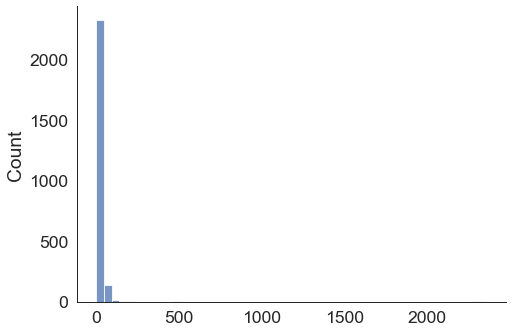

In [32]:
sns.set_style('white')
sns.set_context("paper", font_scale = 2)
sns.displot(data=intervals, kind="hist", bins = 50, aspect = 1.5)

In [33]:
#  extract best fitting distribution
f = Fitter(intervals)
f.fit()
f.summary()


KeyboardInterrupt



In [ ]:
f.get_best(method = 'sumsquare_error')